In [1]:
cd /home/users/cdonoso/astromer/ASTROMER/

/home/users/cdonoso/astromer/ASTROMER


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

from core.data import pretraining_records
from sklearn.metrics import precision_recall_fscore_support
from presentation.scripts.backprop import NormedLSTMCell
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Something GPU-related is solved when using the following lines.
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

%load_ext autoreload
%autoreload 2

In [3]:
num_cls = pd.read_csv(os.path.join('./data/records/alcock', 'objects.csv')).shape[0]

In [4]:
test_ds = pretraining_records(os.path.join('./data/records/alcock/fold_0/alcock/', 'test/'),
                     256, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0.,
                     sampling=False, shuffle=False,
                     n_classes=num_cls)
y_true = np.concatenate([np.argmax(y, 1) for _, y in test_ds])

2021-12-09 09:25:35.478630: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 09:25:35.864857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22355 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:82:00.0, compute capability: 8.6


[INFO] Processing labels


2021-12-09 09:25:37.030089: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
def get_prediction(data, folder):
    model = tf.keras.models.load_model(folder, custom_objects={'NormedLSTMCell':NormedLSTMCell})
    y_pred = model.predict(data)
    y_pred = tf.argmax(y_pred, 1)
    return y_pred

In [6]:
exp_name = 'alcock'
folds_df = []
for fold_n in range(3):
    results = []
    for model_name in ['lstm', 'lstm_att', 'mlp_att']:
        y_pred = get_prediction(test_ds, './experiments_6/{}/fold_{}/{}/{}/model/'.format(exp_name, fold_n, exp_name, model_name))
        prec, reca, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        results.append([exp_name, model_name, f1, prec, reca])
        
    df_results = pd.DataFrame(results, columns=['exp', 'model', 'f1', 'recall', 'precision'])
    df_results['fold'] = [fold_n]*df_results.shape[0]
    folds_df.append(df_results)

2021-12-09 09:25:59.983257: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-12-09 09:26:00.565860: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2021-12-09 09:26:04.212101: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-09 09:26:04.744548: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies sh

2021-12-09 09:26:30.287302: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-09 09:26:30.467720: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-09 09:26:30.530688: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-09 09:26:30.697503: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-09 09:26:30.710301: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes at

2021-12-09 09:26:55.834253: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-09 09:26:55.855492: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-09 09:26:55.867542: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-09 09:26:55.973935: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-09 09:26:56.075101: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes at

In [34]:
pd.concat(folds_df, 0).groupby('model').mean()

/tmp/ipykernel_3948470/644615393.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pd.concat(folds_df, 0).groupby('model').mean()


,f1,recall,precision,fold
model,,,,
lstm,0.349650,0.357711,0.386111,1.0
lstm_att,0.840241,0.839998,0.841866,1.0
mlp_att,0.588879,0.638940,0.577573,1.0


In [13]:
# y_true = tf.concat([tf.argmax(y, 1) for _, y in ds], 0)

In [14]:
exp_name = 'alcock'

for fold_n in range(3):
    results = []
    for dataset in ['{}_20'.format(exp_name), '{}_50'.format(exp_name), '{}_100'.format(exp_name), '{}_500'.format(exp_name)]:
#         ds_path = './data/records/alcock/fold_{}/{}/'.format(fold_n, dataset)
#         test_ds = pretraining_records(os.path.join(ds_path, 'test/'),
#                              256, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0.,
#                                         sampling=False, shuffle=False,
#                                         n_classes=num_cls)
#         y_true = np.concatenate([np.argmax(y, 1) for _, y in test_ds])
        for model_name in ['lstm', 'lstm_att', 'mlp_att']:
            path = './experiments_6/{}/fold_{}/{}/'.format(exp_name, fold_n, dataset)
            y_pred = get_prediction(test_ds, os.path.join(path, model_name, 'model'))

            prec, reca, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            results.append([dataset, model_name, f1, prec, reca])
            
    df_results = pd.DataFrame(results, columns=['exp', 'model', 'f1', 'recall', 'precision'])
    df_results.to_csv('./experiments_6/{}/results_st_{}.csv'.format(exp_name, fold_n), index=False)

2021-12-07 12:20:16.809881: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:20:17.067441: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:20:17.498223: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:20:17.511448: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:20:18.939886: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

2021-12-07 12:20:43.421886: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:20:44.930343: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:20:44.950229: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:20:45.210080: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:20:45.222963: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

2021-12-07 12:21:09.709688: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:21:09.722083: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:21:09.826479: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:21:09.838715: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:21:27.921982: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

2021-12-07 12:21:53.213584: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:21:54.548484: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:21:54.560842: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:21:54.809440: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:21:55.126615: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes at

2021-12-07 12:22:19.005162: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:22:19.018537: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:22:19.175055: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:22:19.187268: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:22:19.658979: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

2021-12-07 12:23:03.984061: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:23:03.996633: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:23:04.234164: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:23:04.476235: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:23:04.488834: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

2021-12-07 12:23:29.548169: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:23:29.560463: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:23:29.608059: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:23:29.683580: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:23:29.695792: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes at

2021-12-07 12:23:54.370590: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:23:54.382888: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:24:12.878339: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:24:13.977175: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:24:13.989933: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

2021-12-07 12:24:38.734515: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:24:38.813384: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:24:38.825454: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:24:38.925617: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-12-07 12:24:39.243885: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

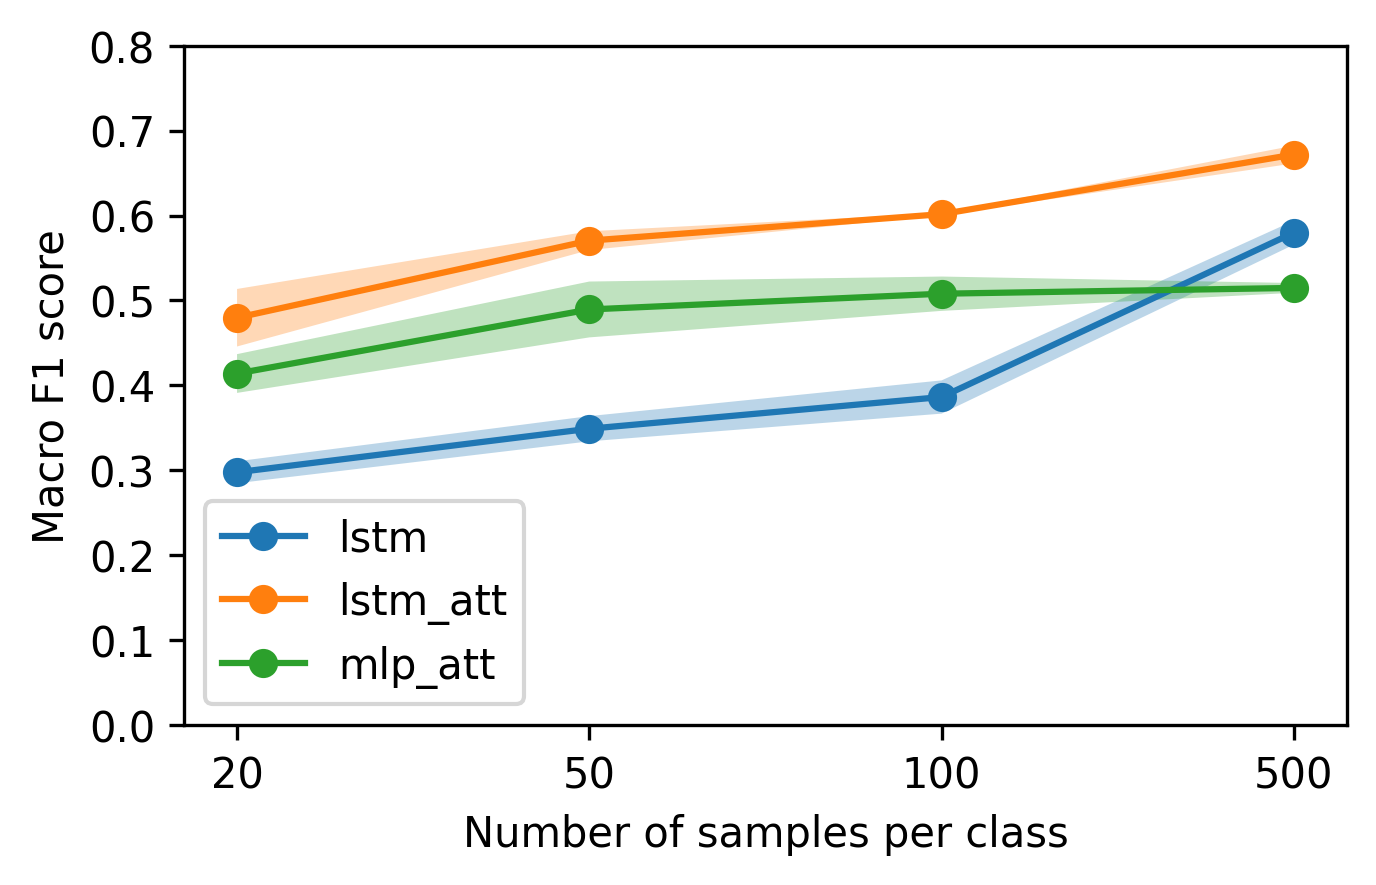

In [16]:
plt.figure(figsize=(5,3), dpi=300)
for (exp0, g0), (exp1, g1), (exp2, g2) in zip(fold_0.groupby('model'), fold_1.groupby('model'), fold_2.groupby('model')):
    
    f1_mean = np.mean([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)
    f1_std = np.std([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)

    xrange = range(len(g0['exp'][:]))    
    plt.plot(xrange, f1_mean, marker='o',label=exp0)
    plt.fill_between(xrange, f1_mean+f1_std, f1_mean-f1_std, alpha=0.3)
    plt.xticks(xrange, [x.split('_')[-1] for x in g0['exp'][:]])

plt.ylim(0, 0.8)
plt.ylabel('Macro F1 score')
plt.xlabel('Number of samples per class')
plt.legend()#loc='lower right')
plt.show()

In [9]:
from tensorboard.backend.event_processing import event_accumulator
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)
def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [14]:
exp_folder = './experiments_5/alcock/fold_0/alcock_100/'

dict_keys(['epoch_loss', 'epoch_accuracy'])
dict_keys(['epoch_loss', 'epoch_accuracy'])
dict_keys(['epoch_loss', 'epoch_accuracy'])


Text(0.0, 0.5, 'Categorical Cross Entropy')

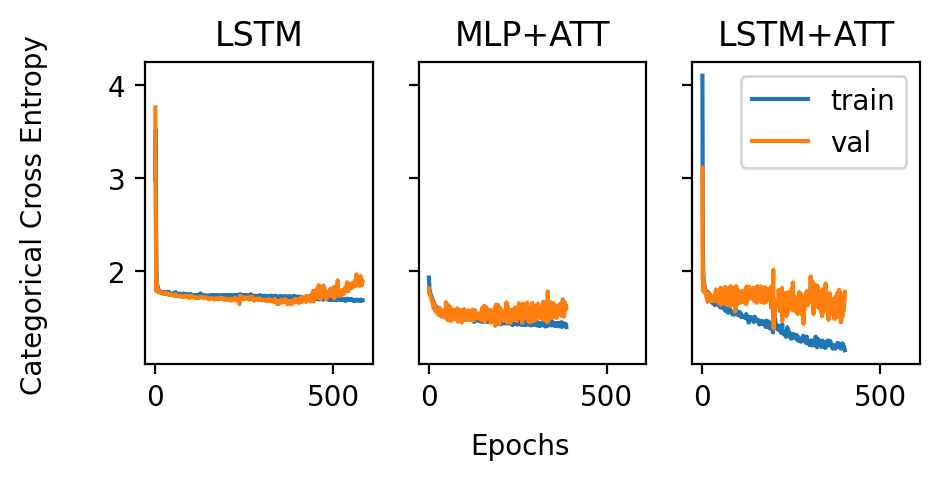

In [15]:
fig, axes = plt.subplots(1,3, sharey=True,sharex=True, figsize=(5,2), dpi=200, 
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
#     if name != 'lstm':continue
    val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'validation'))
    train_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'train'))
    print(train_metrics.keys())
    axes[index].plot(train_metrics['epoch_loss'], label='train')
    axes[index].plot(val_metrics['evaluation_loss_vs_iterations'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    
#     axes[index].set_yscale('log')

axes[-1].legend()
fig.text(0.5, -0.1, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Categorical Cross Entropy', va='center', rotation='vertical')